In [1]:
import missingno
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#데이터 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- feature mean :
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

# 데이터 전처리 
## 0. 결측치 확인
- maso lib을 사용하여 시각적으로 결측치가 있는지 확인해본다.
- 사용한 데이터 셋에서 결측치가 없었기 때문에  따로 처리하지는 않았따.

<AxesSubplot:>

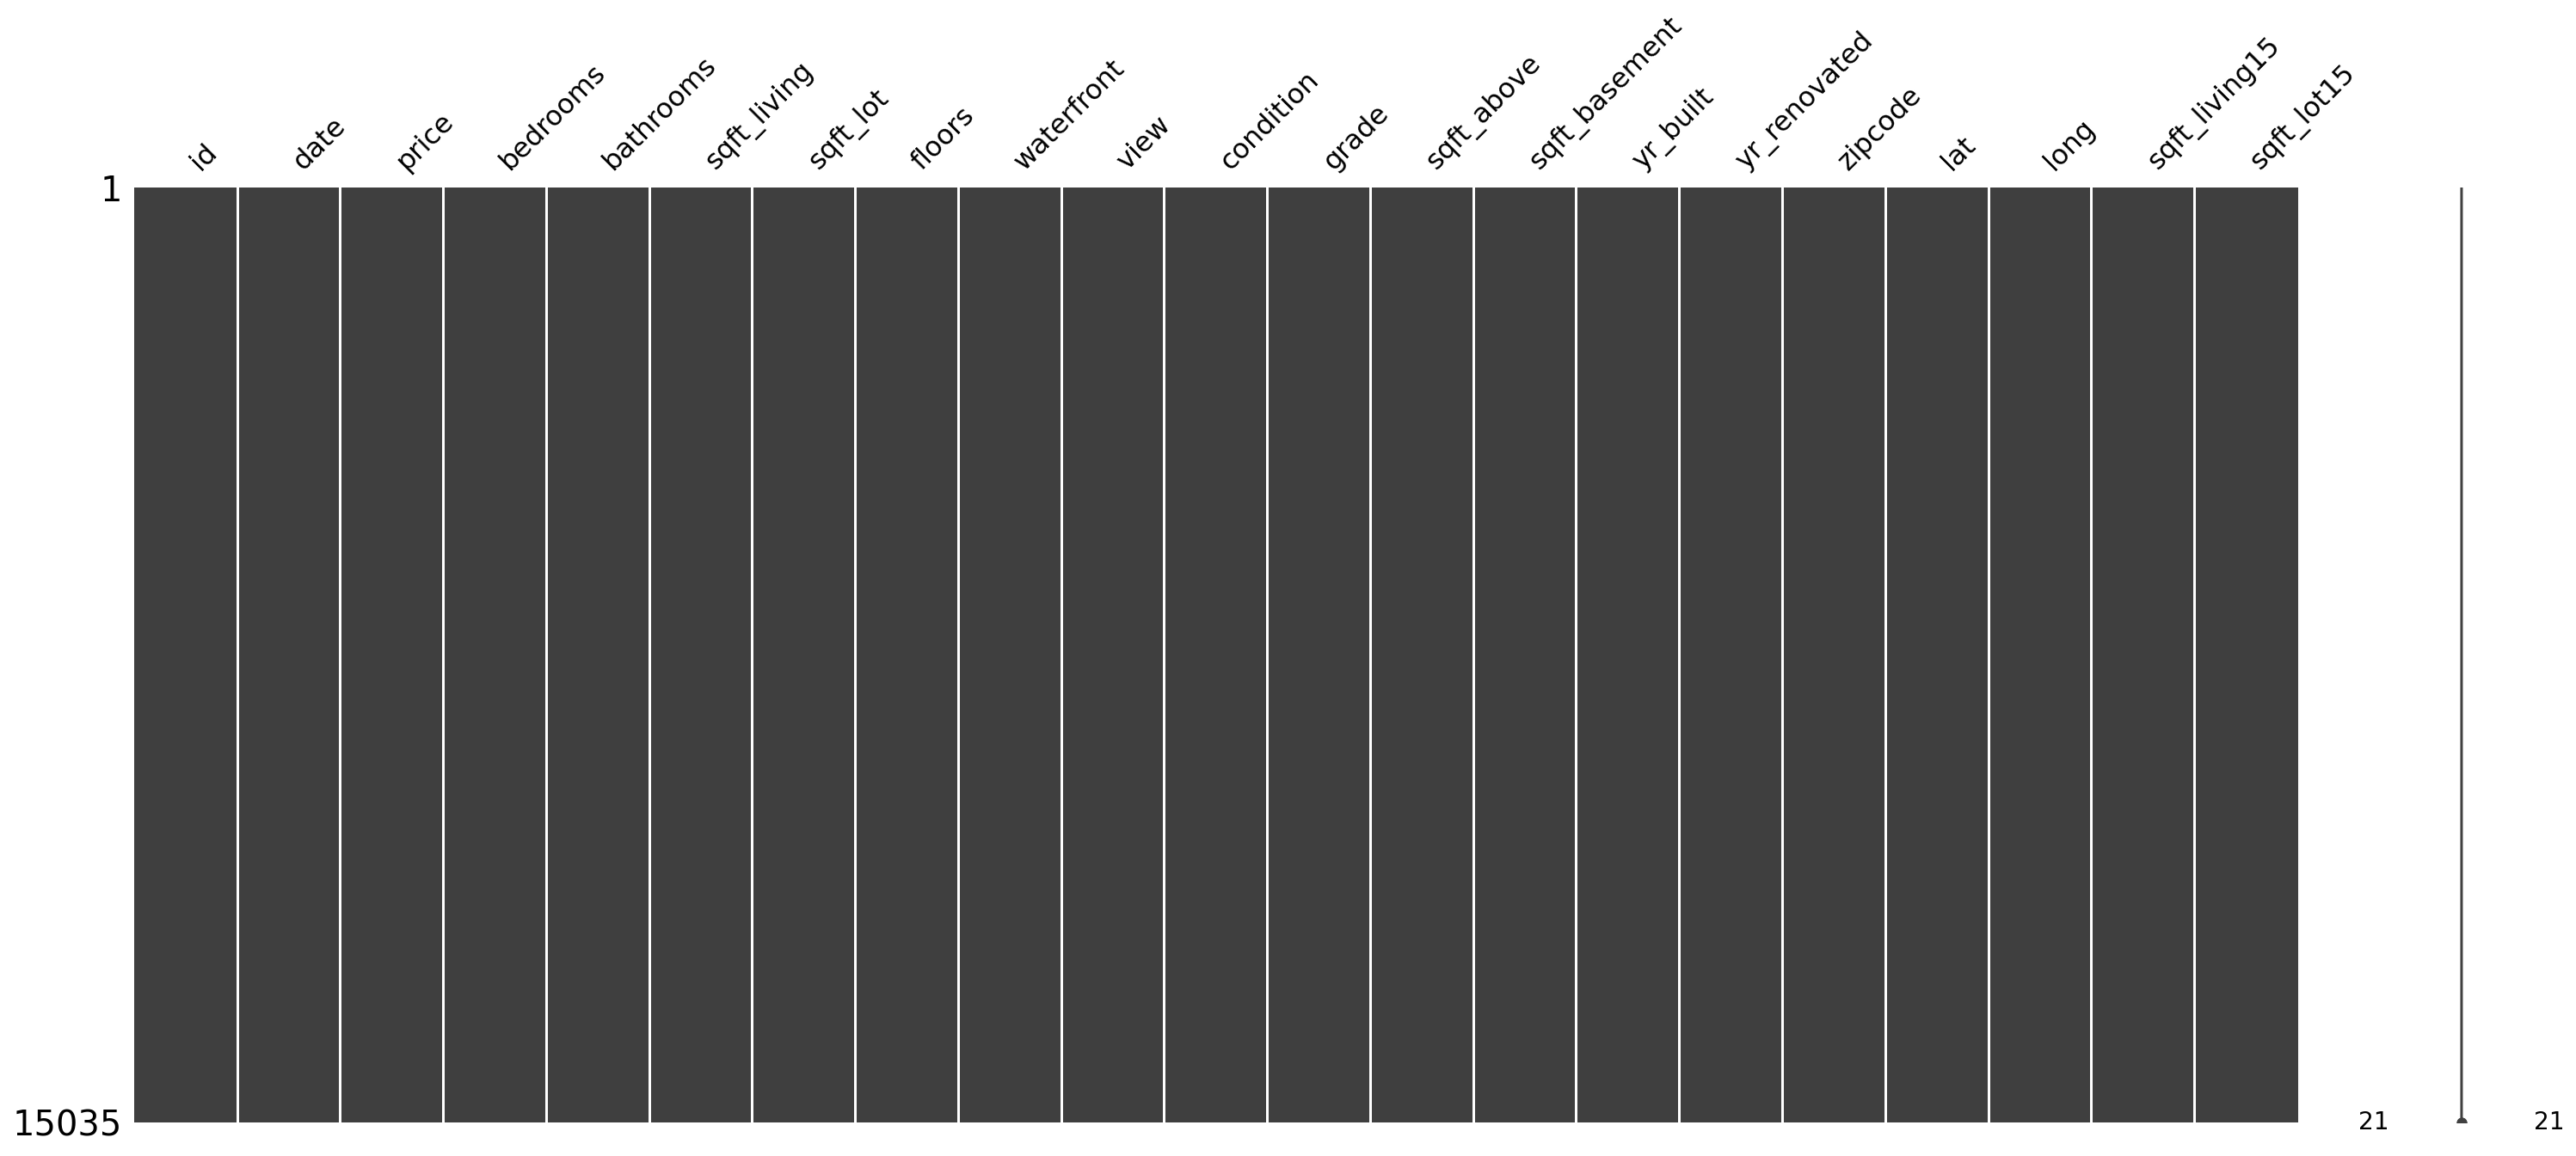

In [3]:
msno.matrix(train)


## 1. 필요없는 데이터 제거 및 변경
- date에서 T뒤의 문자열을 제거 한뒤 int형으로 바꿔준다.
- price는 타깃데이터이기 때문에 데이터셋에선 지워주고 y변수에 따로 저장한다.
- id는 각 집의 식별을 하기위한 데이터이기 때문에 price를 찾는데는 쓸모없다고 판단-> 삭제 

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


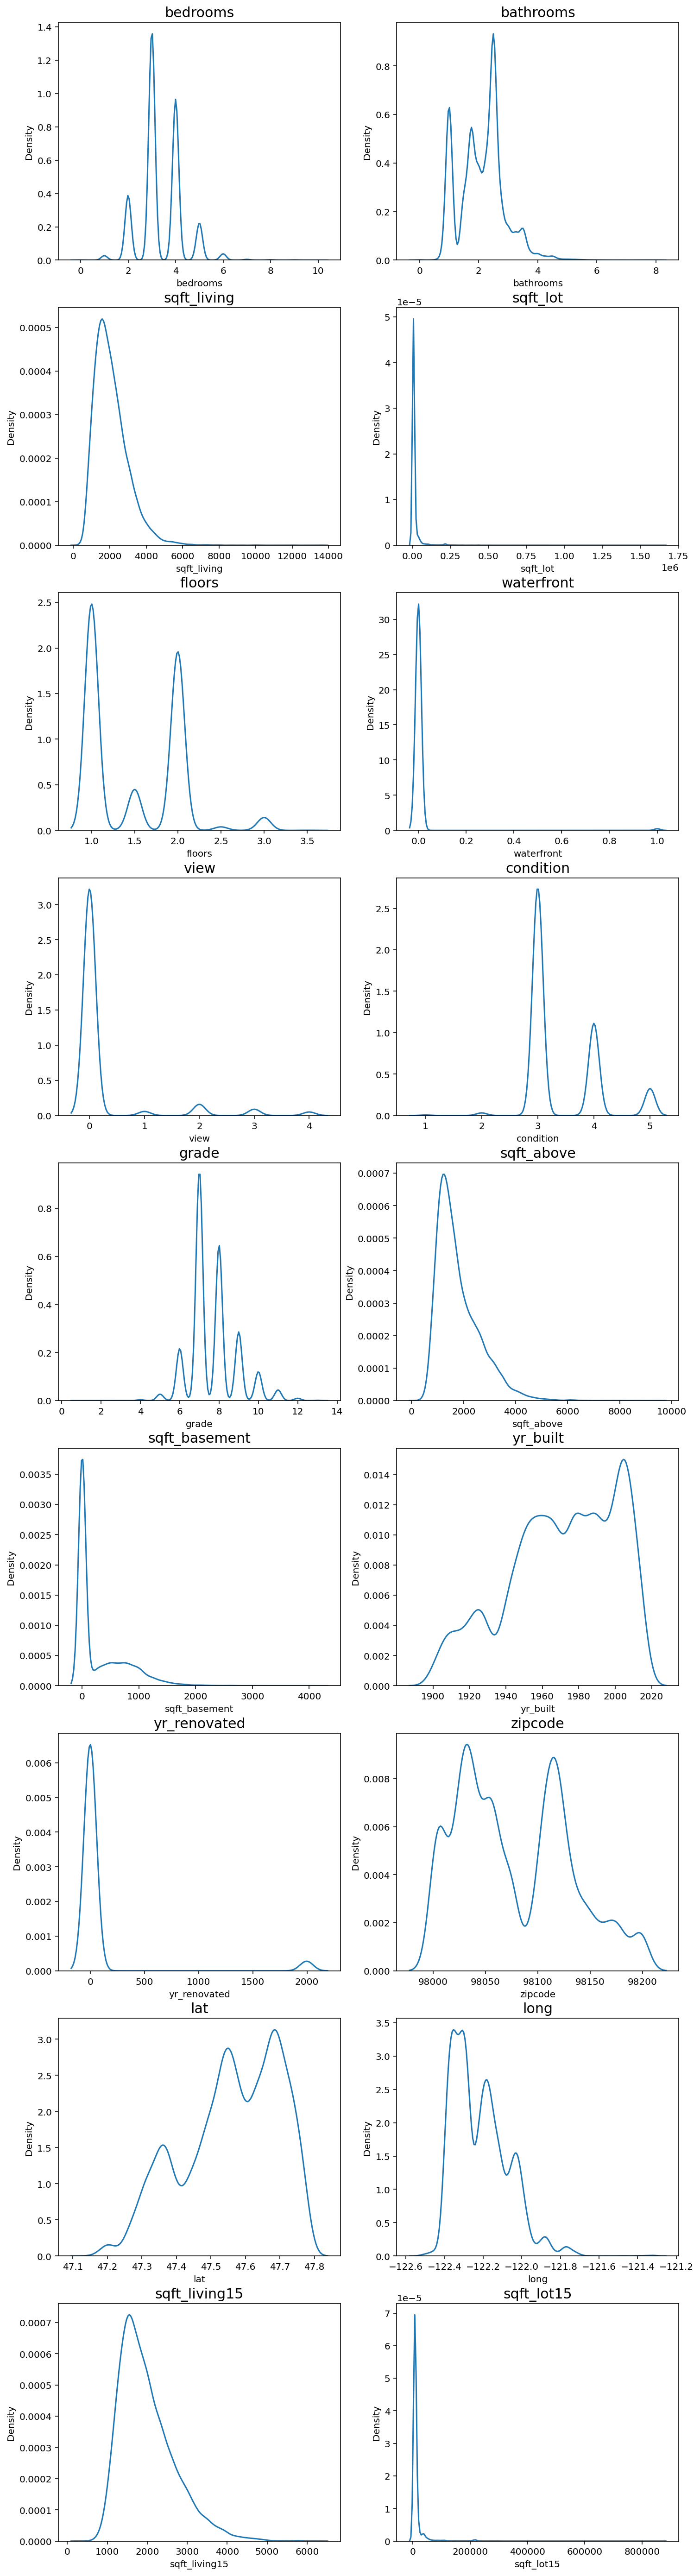

In [8]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

- histplot은 절대량이라면 kdeplot은 밀도 추정치를 시각화한다. 그래서 결과물로는 연속된 곡선의 그래프를 얻을 수 있다
-  밀도추정치 그래프가 너무 쏠려있는 데이터들은 log함수를 통해 펼쳐준다. (너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로)

In [9]:
#한 쪽으로 치우친 데이터들 정규화

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

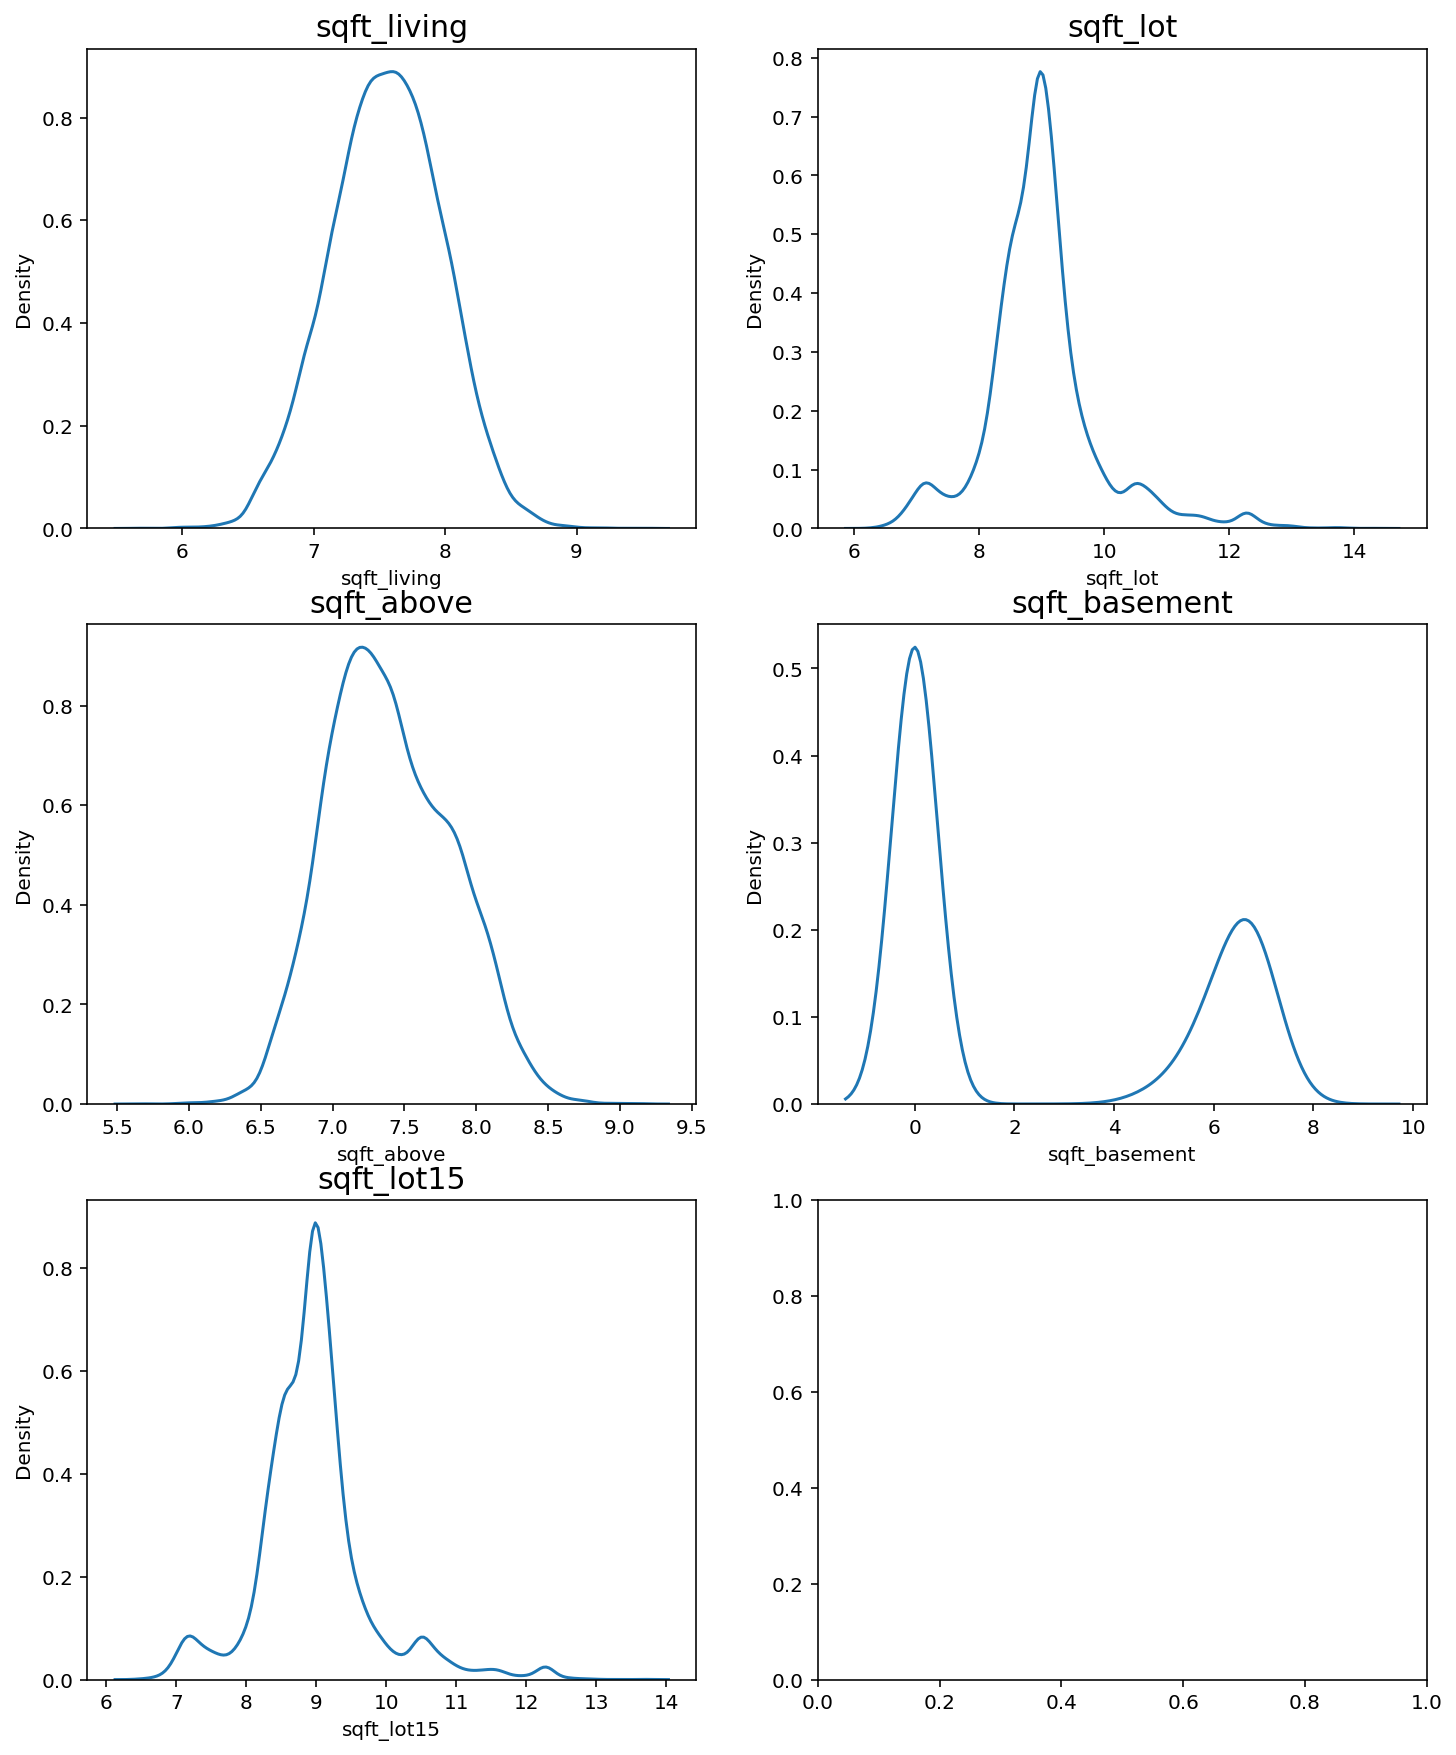

In [10]:
#정규화 되었는지 확인
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

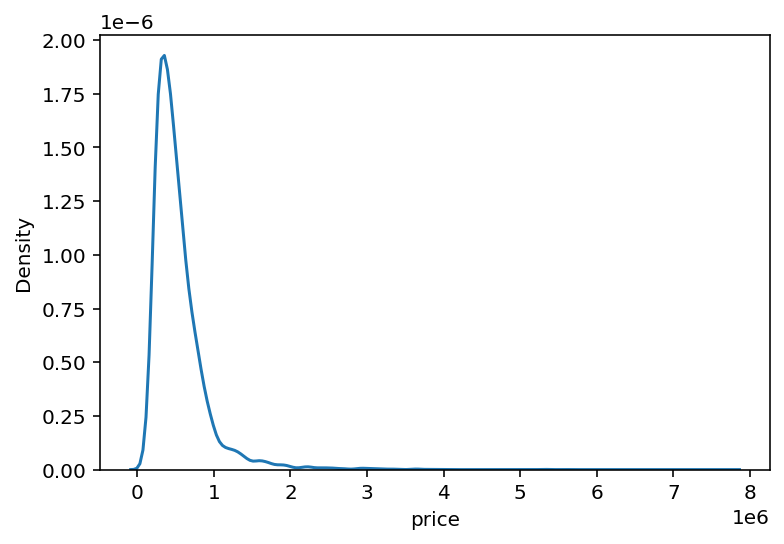

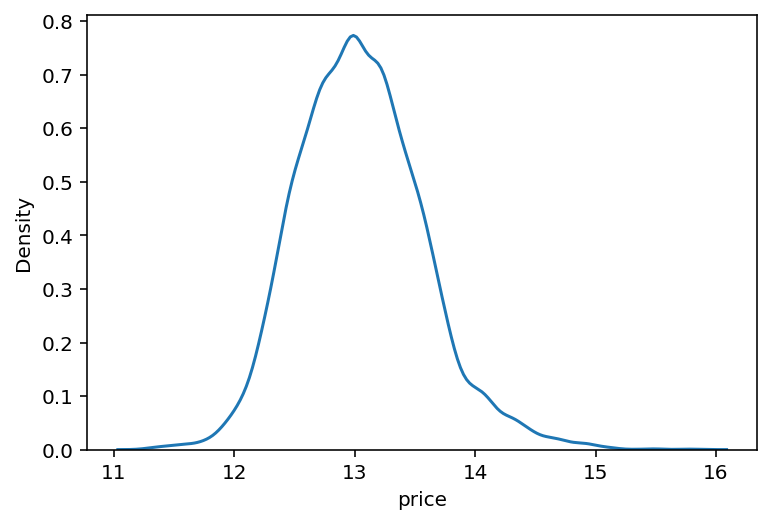

In [11]:
sns.kdeplot(y)
plt.show()
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

- target인 price 분포는 0 쪽으로 매우 심하게 치우쳐져 있는 분포를 보인다.
- 즉, 0과 1000000 사이에 대부분의 값들이 몰려있고, 아주 소수의 집들이 굉장히 높은 가격을 보인다.
- 왼쪽으로 치우친 값들은 보다 넓은 범위로 고르게 퍼지게 하고 오른쪽으로 얇고 넓게 퍼진 값들은 보다 작은 범위로 모이게 하기 위해 로그변환을 하였음

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [13]:
#모델 튜닝

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

#RMSE 계산 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [14]:
random_state=300

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [15]:
#각 모델들의 RMSE 확인

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,136463.010524
RandomForestRegressor,135518.825937
LGBMRegressor,124816.868786
XGBRegressor,122701.587376


- 모델 튜닝을 위한  RMSE 확인

rmse가 적은 모델 XGB와 LGBM의 하이퍼 파라메타 튜닝을 하면되겠다고 생각했다.

# lgbm 하이퍼 파라메타 튜닝
### 0. lgmb의 하이퍼파라메타 종류

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F1PyOG%2FbtqzusXhcyY%2FwijjRmggTpggOpi4GKMEQ1%2Fimg.png)

### 1.튜닝 방법은 랜덤 서치 :
- 파라메타는 num_leaves의 개수와 min_child_sampes(min_data_in_leaf), max_depth를 함께 조절하면서 모델의 복잡도를 줄여볼려함
- num_leaves를 늘리면 정확도가 높아지지만 트리가 깊어지고 과접합되기 쉬움
- min_child_samples(min_data_in_leaf)를 크게 설정하면 트리가 깊어지는 것을 방지
- max_depth는 명시적으로 깊이를 제한. 위의 두 파라미터와 함꼐 과적합을 개선하는데 사용

In [16]:
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint 

In [17]:
def my_RanSearch(model, train, y, params, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    Ransearch_model =  RandomizedSearchCV(model, params, random_state=200, cv=2, n_iter=25, scoring='neg_mean_squared_error',n_jobs=n_jobs)

    # 모델 fitting
    Ransearch_model.fit(train, y)

    # 결과값 저장
    params = Ransearch_model.cv_results_['params']
    score = Ransearch_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [18]:
params = {

    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [4,8,16,32], 
    'num_leaves' :[4,8,16,32],
    'min_child_samples' : [4,8,16,32], 
}

model = LGBMRegressor(random_state=random_state)
ran_search = my_RanSearch(model, train, y, params, verbose=2, n_jobs=5)

In [19]:
ran_search

,num_leaves,min_child_samples,max_depth,learning_rate,score,RMSLE
15,32,32,16,0.10,-0.027967,0.167234
12,32,4,8,0.10,-0.028694,0.169393
23,16,8,8,0.10,-0.029213,0.170920
10,16,4,8,0.10,-0.029524,0.171825
14,32,16,16,0.05,-0.030077,0.173427
22,32,16,4,0.10,-0.030730,0.175299
16,8,8,32,0.10,-0.031728,0.178122
5,8,4,32,0.10,-0.031957,0.178766
18,16,32,8,0.05,-0.032094,0.179149
3,8,8,4,0.10,-0.032231,0.179530


### 2. RMSLE가 가장적은 hyper parametal 조합으로  LGBM모델 구성 및 학습

In [22]:
model = LGBMRegressor(num_leaves=32,max_depth=16,min_child_sample=32,learning_rate=0.1)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Unknown parameter: min_child_sample


array([13.17411719, 13.03334006, 14.15332442, ..., 13.02518219,
       12.69475223, 12.96992017])

### 3. 예측값을 저장하고 제출

In [23]:
prediction = np.expm1(prediction)
prediction

array([ 526557.22231967,  457411.122794  , 1401878.5400151 , ...,
        453694.79386005,  326031.46187441,  429302.82851517])

In [24]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [25]:
save_submission(model, train, y, test, 'lgbm', rmsle='first_lgbm')

[LightGBM] [Warning] Unknown parameter: min_child_sample
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_first_lgbm.csv saved!


### 결과는 116121.88439 생각보다 쉽지 않다.

### 1.1 튜닝 방법 :

http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/

링크에 있는 중요도 있는 파라메타들도 같이 튜닝 해보기로 했다.
- learning_rate
- num_iterations
- max_depth
- bagging_fraction / subsample 
- boosting / booster 

In [26]:
params = {

    'learning_rate': [0.1, 0.05,0.01], 
    'max_depth': [4,8,16,32,64], 
    'num_leaves' :[4,8,16,32],
    'n_estimators':[1000,1500,2000],
    'min_child_samples' : [4,8,16,32],
    'bagging_fraction':[0.5,0.75,1]
}

model = LGBMRegressor(random_state=random_state)
ran_search = my_RanSearch(model, train, y, params, verbose=2, n_jobs=5)

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


In [27]:
ran_search

,num_leaves,n_estimators,min_child_samples,max_depth,learning_rate,bagging_fraction,score,RMSLE
20,8,1000,32,4,0.10,0.75,-0.027312,0.165262
6,16,1500,32,64,0.05,0.50,-0.027415,0.165574
23,16,2000,32,64,0.01,0.50,-0.027426,0.165609
2,16,1000,32,4,0.05,0.50,-0.027448,0.165676
11,4,1000,32,8,0.10,1.00,-0.027478,0.165766
14,8,1500,8,8,0.05,0.75,-0.027543,0.165962
12,4,2000,4,32,0.10,1.00,-0.027628,0.166215
22,16,2000,8,16,0.01,0.75,-0.027806,0.166750
13,16,2000,16,16,0.05,0.75,-0.027829,0.166819
8,16,2000,16,16,0.05,1.00,-0.027829,0.166819


In [28]:
model = LGBMRegressor(num_leaves=8,n_estimators=1000,min_child_samples=32,max_depth=4,learning_rate=0.10,bagging=0.75)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.17961275, 13.06914804, 14.12915219, ..., 13.09695313,
       12.66377405, 13.05001288])

In [29]:
save_submission(model, train, y, test, 'lgbm', rmsle='second_lgbm')

[LightGBM] [Warning] bagging_fraction is set with bagging=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_second_lgbm.csv saved!


In [31]:
params = {

    'learning_rate': [0.1, 0.05,0.01], 
    'max_depth': [4,8,16,32,64], 
    'num_leaves' :[4,8,16,32],
    'n_estimators':[1000,1500,2000],
    'min_child_samples' : [4,8,16,32],
    'bagging':[0.5,0.75,1.0],
    'feature_fraction':[0.7,0.5,0.9]
}

model = LGBMRegressor(random_state=random_state)
ran_search = my_RanSearch(model, train, y, params, verbose=2, n_jobs=5)

In [32]:
ran_search

,num_leaves,n_estimators,min_child_samples,max_depth,learning_rate,feature_fraction,bagging,score,RMSLE
15,8,1500,32,4,0.05,0.5,1.00,-0.026932,0.164111
18,16,1500,16,8,0.05,0.5,1.00,-0.027125,0.164696
17,8,2000,16,32,0.05,0.7,1.00,-0.027134,0.164725
7,32,1500,16,4,0.05,0.5,0.75,-0.027292,0.165202
6,4,1500,16,16,0.10,0.5,0.50,-0.027336,0.165336
0,16,1500,32,16,0.05,0.9,0.50,-0.027337,0.165339
20,8,1000,32,64,0.05,0.9,1.00,-0.027351,0.165380
1,8,2000,4,32,0.05,0.7,1.00,-0.027367,0.165431
19,32,1000,32,32,0.01,0.9,1.00,-0.027438,0.165645
9,8,1500,32,32,0.10,0.7,0.50,-0.027529,0.165919


In [33]:
model = LGBMRegressor(num_leaves=8,n_estimators=1500,min_child_samples=32,max_depth=4,learning_rate=0.05,feature_fraction=0.5,bagging=1)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.17341804, 12.97603744, 14.13888619, ..., 13.0763611 ,
       12.63219727, 12.96646623])

In [34]:
save_submission(model, train, y, test, 'lgbm', rmsle='third_lgbm')

[LightGBM] [Warning] bagging_fraction is set with bagging=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_third_lgbm.csv saved!


# 결과
![ex_screenshot](./first.PNG)
![ex_screenshot](./second.PNG)
![ex_screenshot](./third.PNG)

# 회고 :  
## grid search 보단 randomized search가 좋다길래 썼다.(하이퍼 파라메타 마다 중요도가 달라서)
## hyperparameta에 대한 이해도가 높아야 된다는 것을 느꼈다.처음에는  중요도와 파라메타의 의미를 몰랐는데 문서를 좀 읽고 조합을 맞추게 하여 튜닝을 하였더니 좋은 조합들이 나왔따.
## 이때까지 한 노드들의 데이터 전처리 과정과 데이터를 보는 법을 이제는 체화가 된 것같다. 그리고 데이터의 정규화를 위한 log 함수를 입히는 것을 배웠다.